<a href="https://colab.research.google.com/github/RANJEET16520/Humour-Detection/blob/master/Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 12.7 GB  |     Proc size: 159.7 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total     11441MB


In [ ]:
!pip install transformers
!pip install pytorch_transformers

In [ ]:
import os
import math
import glob
import logging

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import XLNetTokenizer, XLNetModel, XLNetLMHeadModel, XLNetConfig, XLNetForSequenceClassification
from pytorch_transformers import AdamW, WarmupLinearSchedule
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
from sklearn.metrics import mean_squared_error, matthews_corrcoef, confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
print("GPU Available: {}".format(torch.cuda.is_available()))
n_gpu = torch.cuda.device_count()
print("Number of GPU Available: {}".format(n_gpu))
print("GPU: {}".format(torch.cuda.get_device_name(0)))
print("Current Device is {}".format('GPU' if torch.cuda.current_device()==0 else 'CPU'))
torch.cuda.set_device(0)

GPU Available: True
Number of GPU Available: 1
GPU: Tesla K80
Current Device is GPU


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
test = pd.read_csv('/content/drive/My Drive/Data/New_200K_Jokes/dev.csv')
test.shape

(40000, 2)

In [ ]:
test.head(10)

,text,humor
0,What kind of cat should you take into the des...,True
1,Remember when people used to have to be in sha...,True
2,Pizza is always good. - everyone we'll see abo...,True
3,"What's 6 inches long hard, bent, and in my pan...",True
4,Black teen's response to violence in his commu...,False
5,"'make me a sandwich' is making us hungry, deli...",False
6,Do infants have as much fun in infancy as adul...,True
7,Funded kickstarters: food products we can't wa...,False
8,What has 125 teeth and prevents a savage beast...,True
9,What happened to the adhesive suicide bomber? ...,True


In [ ]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

INFO:transformers.tokenization_utils_base:loading file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-spiece.model from cache at /root/.cache/torch/transformers/dad589d582573df0293448af5109cb6981ca77239ed314e15ca63b7b8a318ddd.8b10bd978b5d01c21303cc761fc9ecd464419b3bf921864a355ba807cfbfafa8


In [ ]:
test_text_list = test["text"].values

In [ ]:
def tokenize_inputs(text_list, tokenizer, num_embeddings):
    """
    Tokenizes the input text input into ids. Appends the appropriate special
    characters to the end of the text to denote end of sentence. Truncate or pad
    the appropriate sequence length.
    """
    # tokenize the text, then truncate sequence to the desired length minus 2 for
    # the 2 special characters
    tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:num_embeddings-2], text_list))
    # convert tokenized text into numeric ids for the appropriate LM
    input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
    # append special token "<s>" and </s> to end of sentence
    input_ids = [tokenizer.build_inputs_with_special_tokens(x) for x in input_ids]
    # pad sequences
    input_ids = pad_sequences(input_ids, maxlen=num_embeddings, dtype="long", truncating="post", padding="post")
    input_ids = np.array(input_ids)
    return input_ids

def create_attn_masks(input_ids):
    """
    Create attention masks to tell model whether attention should be applied to
    the input id tokens. Do not want to perform attention on padding tokens.
    """
    # Create attention masks
    attention_masks = []

    # Create a mask of 1s for each token followed by 0s for padding
    for seq in input_ids:
        seq_mask = [float(i>0) for i in seq]
        attention_masks.append(seq_mask)
    attention_masks = np.array(attention_masks)
    return attention_masks

In [ ]:
# create input id tokens
test_input_ids = tokenize_inputs(test_text_list, tokenizer, num_embeddings=50)
print(test_input_ids.shape)
test_input_ids

(40000, 50)


array([[  113,   713,    20, ...,     0,     0,     0],
       [ 1633,    90,   104, ...,     0,     0,     0],
       [12879,    27,   426, ...,     0,     0,     0],
       ...,
       [  160,   142,  8959, ...,     0,     0,     0],
       [   17,    98,   369, ...,     0,     0,     0],
       [   48,    17,  1121, ...,     0,     0,     0]])

In [ ]:
# create attention masks
test_attention_masks = create_attn_masks(test_input_ids)
test_attention_masks.shape

(40000, 50)

In [ ]:
test["features"] = test_input_ids.tolist()
test["masks"] = test_attention_masks.tolist()
test.head()

,text,humor,features,masks
0,What kind of cat should you take into the des...,True,"[113, 713, 20, 4777, 170, 44, 182, 91, 18, 567...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
1,Remember when people used to have to be in sha...,True,"[1633, 90, 104, 179, 22, 47, 22, 39, 25, 2787,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
2,Pizza is always good. - everyone we'll see abo...,True,"[12879, 27, 426, 195, 9, 17, 13, 1251, 80, 26,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
3,"What's 6 inches long hard, bent, and in my pan...",True,"[113, 26, 23, 284, 3763, 206, 500, 19, 9015, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."
4,Black teen's response to violence in his commu...,False,"[710, 8017, 26, 23, 1196, 22, 1350, 25, 45, 53...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ..."


In [ ]:
#config = XLNetConfig()
        
class XLNetForMultiLabelSequenceClassification(torch.nn.Module):
  
    def __init__(self, num_labels=1):
        super(XLNetForMultiLabelSequenceClassification, self).__init__()
        self.num_labels = num_labels
        self.xlnet = XLNetModel.from_pretrained('xlnet-base-cased')
        self.classifier = torch.nn.Linear(768, num_labels)

        torch.nn.init.xavier_normal_(self.classifier.weight)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None):
        # last hidden layer
        last_hidden_state = self.xlnet(input_ids=input_ids,\
                                    attention_mask=attention_mask,\
                                    token_type_ids=token_type_ids)
        # pool the outputs into a mean vector
        mean_last_hidden_state = self.pool_hidden_state(last_hidden_state)
        logits = self.classifier(mean_last_hidden_state)
            
        if labels is not None:
            loss_fct = BCEWithLogitsLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))
            return loss
        else:
            return logits

    def freeze_xlnet_decoder(self):
        """
        Freeze XLNet weight parameters. They will not be updated during training.
        """
        for param in self.xlnet.parameters():
            param.requires_grad = False
    
    def unfreeze_xlnet_decoder(self):
        """
        Unfreeze XLNet weight parameters. They will be updated during training.
        """
        for param in self.xlnet.parameters():
            param.requires_grad = True

    def pool_hidden_state(self, last_hidden_state):
        """
        Pool the output vectors into a single mean vector 
        """
        last_hidden_state = last_hidden_state[0]
        mean_last_hidden_state = torch.mean(last_hidden_state, 1)
        return mean_last_hidden_state

model = XLNetForMultiLabelSequenceClassification(num_labels=1)
# model = XLNetForSequenceClassification.from_pretrained('xlnet-base-cased')
model = torch.nn.DataParallel(model)
model.cuda()

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json from cache at /root/.cache/torch/transformers/c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.69e5e35e0b798cab5e473f253752f8bf4d280ee37682281a23eed80f6e2d09c6
INFO:transformers.configuration_utils:Model config XLNetConfig {
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_proj": true,
  "task_sp

DataParallel(
  (module): XLNetForMultiLabelSequenceClassification(
    (xlnet): XLNetModel(
      (word_embedding): Embedding(32000, 768)
      (layer): ModuleList(
        (0): XLNetLayer(
          (rel_attn): XLNetRelativeAttention(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (ff): XLNetFeedForward(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (layer_1): Linear(in_features=768, out_features=3072, bias=True)
            (layer_2): Linear(in_features=3072, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): XLNetLayer(
          (rel_attn): XLNetRelativeAttention(
            (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
        

In [ ]:
def load_model(save_path):
    """
    Load the model from the path directory provided
    """
    checkpoint = torch.load(save_path)
    model_state_dict = checkpoint['state_dict']
    model = XLNetForMultiLabelSequenceClassification(num_labels=model_state_dict["classifier.weight"].size()[0])
    model.load_state_dict(model_state_dict)

    return model

In [ ]:
cwd = os.getcwd()
output_model_file = os.path.join(cwd, "/content/drive/My Drive/Data/New_200K_Jokes/xlnet_toxic.bin")

In [ ]:
model = load_model(output_model_file)

INFO:transformers.configuration_utils:loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/xlnet-base-cased-config.json from cache at /root/.cache/torch/transformers/c9cc6e53904f7f3679a31ec4af244f4419e25ebc8e71ebf8c558a31cbcf07fc8.69e5e35e0b798cab5e473f253752f8bf4d280ee37682281a23eed80f6e2d09c6
INFO:transformers.configuration_utils:Model config XLNetConfig {
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_proj": true,
  "task_sp

In [ ]:
def generate_predictions(model, df, num_labels, device, batch_size=32):
    num_iter = math.ceil(df.shape[0]/batch_size)

    pred_probs = np.array([]).reshape(0, num_labels)

    model.to(device)
    model.eval()
  
    for i in range(num_iter):
        df_subset = df.iloc[i*batch_size:(i+1)*batch_size,:]
        X = df_subset["features"].values.tolist()
        masks = df_subset["masks"].values.tolist()
        X = torch.tensor(X)
        masks = torch.tensor(masks, dtype=torch.long)
        X = X.to(device)
        masks = masks.to(device)
        with torch.no_grad():
            logits = model(input_ids=X, attention_mask=masks)
            logits = logits.sigmoid().detach().cpu().numpy()
            pred_probs = np.vstack([pred_probs, logits])
  
    return pred_probs

In [ ]:
# label_cols = ["Output"]
num_labels = 1
pred_probs = generate_predictions(model, test, num_labels, device, batch_size=32)
pred_probs

array([[9.25646126e-01],
       [2.57031322e-02],
       [2.40021110e-01],
       ...,
       [8.82485509e-01],
       [8.13921819e-09],
       [9.43552673e-01]])

In [ ]:
test["Pre_Prob"] = pred_probs
test.head(10)

,text,humor,features,masks,Pre_Prob
0,What kind of cat should you take into the des...,True,"[113, 713, 20, 4777, 170, 44, 182, 91, 18, 567...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.256461e-01
1,Remember when people used to have to be in sha...,True,"[1633, 90, 104, 179, 22, 47, 22, 39, 25, 2787,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.570313e-02
2,Pizza is always good. - everyone we'll see abo...,True,"[12879, 27, 426, 195, 9, 17, 13, 1251, 80, 26,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.400211e-01
3,"What's 6 inches long hard, bent, and in my pan...",True,"[113, 26, 23, 284, 3763, 206, 500, 19, 9015, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.585403e-01
4,Black teen's response to violence in his commu...,False,"[710, 8017, 26, 23, 1196, 22, 1350, 25, 45, 53...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.463257e-10
5,"'make me a sandwich' is making us hungry, deli...",False,"[17, 26, 15481, 110, 24, 16041, 26, 27, 441, 2...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",4.422126e-10
6,Do infants have as much fun in infancy as adul...,True,"[112, 16540, 47, 34, 178, 1572, 25, 28653, 34,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.647112e-04
7,Funded kickstarters: food products we can't wa...,False,"[7327, 4343, 11119, 270, 60, 626, 678, 80, 64,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.194568e-10
8,What has 125 teeth and prevents a savage beast...,True,"[113, 51, 11518, 4232, 21, 15751, 24, 19814, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.608749e-01
9,What happened to the adhesive suicide bomber? ...,True,"[113, 1525, 22, 18, 24309, 2886, 9768, 82, 43,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.850587e-01


In [ ]:
check_false = test.groupby(['humor']).get_group(False)
check_false

,text,humor,features,masks,Pre_Prob
4,Black teen's response to violence in his commu...,False,"[710, 8017, 26, 23, 1196, 22, 1350, 25, 45, 53...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.463257e-10
5,"'make me a sandwich' is making us hungry, deli...",False,"[17, 26, 15481, 110, 24, 16041, 26, 27, 441, 2...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",4.422126e-10
7,Funded kickstarters: food products we can't wa...,False,"[7327, 4343, 11119, 270, 60, 626, 678, 80, 64,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.194568e-10
10,China says it wants smooth military ties with ...,False,"[17, 18252, 349, 36, 1578, 3893, 370, 3278, 33...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.795978e-10
13,Lance armstrong used rugs: not the headline we...,False,"[17, 15489, 1860, 9420, 179, 26209, 60, 50, 18...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.957825e-10
...,...,...,...,...,...
39991,Meet the billionaire who controls your ketchup...,False,"[767, 18, 19095, 61, 5167, 73, 17, 1235, 4615,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.827663e-07
39992,North korea stages large-scale artillery drill...,False,"[1012, 17, 13204, 4428, 5752, 392, 13, 5339, 8...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.240013e-08
39994,Elizabeth taylor looked amazing even without d...,False,"[17, 530, 16798, 1156, 138, 17, 46, 29317, 719...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.457959e-10
39995,Conor maynard seamlessly fits old-school r&b h...,False,"[2147, 218, 132, 13137, 18644, 111, 11093, 532...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",8.919809e-11


In [ ]:
max(check_false['Pre_Prob'])

0.968752920627594

In [ ]:
check_false.Pre_Prob.describe()

count    1.991800e+04
mean     2.908668e-04
std      1.269746e-02
min      1.814307e-11
25%      5.884997e-10
50%      2.359096e-09
75%      1.751213e-08
max      9.687529e-01
Name: Pre_Prob, dtype: float64

In [ ]:
check_true = test.groupby(['humor']).get_group(True)
check_true

,text,humor,features,masks,Pre_Prob
0,What kind of cat should you take into the des...,True,"[113, 713, 20, 4777, 170, 44, 182, 91, 18, 567...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.925646
1,Remember when people used to have to be in sha...,True,"[1633, 90, 104, 179, 22, 47, 22, 39, 25, 2787,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.025703
2,Pizza is always good. - everyone we'll see abo...,True,"[12879, 27, 426, 195, 9, 17, 13, 1251, 80, 26,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.240021
3,"What's 6 inches long hard, bent, and in my pan...",True,"[113, 26, 23, 284, 3763, 206, 500, 19, 9015, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.958540
6,Do infants have as much fun in infancy as adul...,True,"[112, 16540, 47, 34, 178, 1572, 25, 28653, 34,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.000265
...,...,...,...,...,...
39990,Where do eskimos keep their money? in snowbanks.,True,"[131, 112, 17, 93, 3681, 10532, 435, 58, 356, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.739932
39993,What did the child with no arms get for christ...,True,"[113, 190, 18, 863, 33, 116, 1374, 133, 28, 17...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.934039
39996,How to you make holy water? you boil the hell ...,True,"[160, 22, 44, 144, 7177, 333, 82, 44, 11042, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.177440
39997,How many optometrists does it take to screw in...,True,"[160, 142, 8959, 8662, 7628, 2309, 358, 36, 18...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",0.882486


In [ ]:
min(check_true['Pre_Prob'])

6.538994345994809e-10

In [ ]:
check_true.Pre_Prob.describe()

count    2.008200e+04
mean     5.943290e-01
std      3.872758e-01
min      6.538994e-10
25%      1.600019e-01
50%      7.574874e-01
75%      9.591439e-01
max      9.999506e-01
Name: Pre_Prob, dtype: float64

In [ ]:
test_dup = test

In [ ]:
test_dup['Predicted_Output'] = np.where(test_dup.Pre_Prob > 1e-4, 1, 0)
test_dup.head(10)

,text,humor,features,masks,Pre_Prob,Predicted_Output
0,What kind of cat should you take into the des...,True,"[113, 713, 20, 4777, 170, 44, 182, 91, 18, 567...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.256461e-01,1
1,Remember when people used to have to be in sha...,True,"[1633, 90, 104, 179, 22, 47, 22, 39, 25, 2787,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.570313e-02,1
2,Pizza is always good. - everyone we'll see abo...,True,"[12879, 27, 426, 195, 9, 17, 13, 1251, 80, 26,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.400211e-01,1
3,"What's 6 inches long hard, bent, and in my pan...",True,"[113, 26, 23, 284, 3763, 206, 500, 19, 9015, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.585403e-01,1
4,Black teen's response to violence in his commu...,False,"[710, 8017, 26, 23, 1196, 22, 1350, 25, 45, 53...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",6.463257e-10,0
5,"'make me a sandwich' is making us hungry, deli...",False,"[17, 26, 15481, 110, 24, 16041, 26, 27, 441, 2...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",4.422126e-10,0
6,Do infants have as much fun in infancy as adul...,True,"[112, 16540, 47, 34, 178, 1572, 25, 28653, 34,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",2.647112e-04,1
7,Funded kickstarters: food products we can't wa...,False,"[7327, 4343, 11119, 270, 60, 626, 678, 80, 64,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",1.194568e-10,0
8,What has 125 teeth and prevents a savage beast...,True,"[113, 51, 11518, 4232, 21, 15751, 24, 19814, 1...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.608749e-01,1
9,What happened to the adhesive suicide bomber? ...,True,"[113, 1525, 22, 18, 24309, 2886, 9768, 82, 43,...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",9.850587e-01,1


In [ ]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    return {
        "mcc": mcc,
        "tp": tp,
        "tn": tn,
        "fp": fp,
        "fn": fn
    }

def compute_metrics(preds, labels):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

In [ ]:
result = compute_metrics(test_dup.humor, test_dup.Predicted_Output)
for key in sorted(result.keys()):
    logger.info("  %s = %s", key, str(result[key]))

INFO:__main__:  fn = 303
INFO:__main__:  fp = 478
INFO:__main__:  mcc = 0.960987531579436
INFO:__main__:  tn = 19615
INFO:__main__:  tp = 19604


In [ ]:
from sklearn.metrics import accuracy_score, r2_score, f1_score, fbeta_score, precision_score, recall_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
Y_test, Y_pred = list(test_dup.humor), list(test_dup.Predicted_Output)
for i in range(20):
	print('Actual = {}:, Predicted = {}'.format(Y_test[i], Y_pred[i]))

Actual = True:, Predicted = 1
Actual = True:, Predicted = 1
Actual = True:, Predicted = 1
Actual = True:, Predicted = 1
Actual = False:, Predicted = 0
Actual = False:, Predicted = 0
Actual = True:, Predicted = 1
Actual = False:, Predicted = 0
Actual = True:, Predicted = 1
Actual = True:, Predicted = 1
Actual = False:, Predicted = 0
Actual = True:, Predicted = 0
Actual = True:, Predicted = 1
Actual = False:, Predicted = 0
Actual = False:, Predicted = 0
Actual = True:, Predicted = 1
Actual = True:, Predicted = 1
Actual = False:, Predicted = 0
Actual = False:, Predicted = 0
Actual = False:, Predicted = 0


In [ ]:
acc = accuracy_score(Y_test, Y_pred)
print("Accuracy : {}".format(acc))  

Accuracy : 0.980475


In [ ]:
error = mean_absolute_error(Y_test, Y_pred)
print("Mean Absolute Error : {}".format(error))

Mean Absolute Error : 0.019525


In [ ]:
error = mean_squared_error(Y_test, Y_pred)
print("Mean Squared Error : {}".format(error))

Mean Squared Error : 0.019525


In [ ]:
score = r2_score(Y_test, Y_pred)
print("R2 Score : {}".format(score))

R2 Score : 0.9218986871169305


In [ ]:
score = precision_score(Y_test, Y_pred, average='macro')
print("Precision Score : {}".format(score))

Precision Score : 0.9804949220014509


In [ ]:
score = recall_score(Y_test, Y_pred, average='macro')
print("Recall Score : {}".format(score))

Recall Score : 0.980492609580767


In [ ]:
score = f1_score(Y_test, Y_pred)
print("F1 Score : {}".format(score))

F1 Score : 0.9804696291480156


In [ ]:
score = fbeta_score(Y_test, Y_pred, beta = 0.5)
print("F-Beta Score : {}".format(score))

F-Beta Score : 0.983050847457627


In [ ]:
jokes_roc = roc_auc_score(Y_test, Y_pred)
print('Jokes: ROC-Area Under Curve = {}'.format(jokes_roc))

Jokes: ROC-Area Under Curve = 0.980492609580767


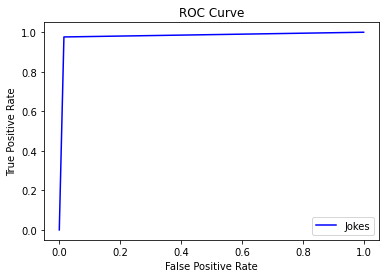

In [ ]:
J_fpr, J_tpr, _ = roc_curve(Y_test, Y_pred)
plt.plot(J_fpr, J_tpr, color = 'blue', label = 'Jokes')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()